# Magnetism

Magntism is only available in Refl1d and it does not support RepeatingMultilayer



## Setup
First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipp as sc


import easyreflectometry
import refl1d

from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.experiment import Model
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Material
from easyreflectometry.sample import Multilayer
from easyreflectometry.sample import Sample
from easyreflectometry.plot import plot

For reference we fetch the version of the software packages we are using. 

In [2]:
print(f'numpy: {np.__version__}')
print(f'scipp: {sc.__version__}')
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refl1d: {refl1d.__version__}')

numpy: 1.26.4
scipp: 24.02.0
easyreflectometry: 0.0.0
refl1d: 0.8.16


## Building our model

The system that was used to produce the data shown above is based on a silicon subphase with two layers upon it. 
These two layers are charachterized by having a scattering length density (SLD) of respectively 4 and 8.
Both layers have a rougness of 2 but their thicknesses are 100 and 150 angstrom respectively.
We show the model that will be used graphically below. 

<center>
    <img src='_static/two_layers.png' alt='A slab model description of the two_layers system.' width='300px'></img>
</center>
<center>
    A slab model description of the two layer.
</center>

To construct such a layer structure, first we create each of the materials, the associated layers, and the sub and super phases. 

In [3]:
sld_4 = Material(sld=4.0, isld=0, name='Sld 4')
sld_8 = Material(sld=8.0, isld=0, name='Sld 8')
vacuum = Material(sld=0, isld=0, name='Vacuum')
si = Material(sld=2.047, isld=0, name='Si')

In [4]:
sld_4_layer = Layer(material=sld_4, thickness=100, roughness=2, name='SLD 4 Layer')
sld_8_layer = Layer(material=sld_8, thickness=150, roughness=2, name='SLD 8 Layer')
superphase = Layer(material=vacuum, thickness=0, roughness=0, name='Vacuum Superphase')
subphase = Layer(material=si, thickness=0, roughness=2, name='Si Subphase')

Then, to produce the two layered structure, we use the `Multilayer` [assembly type](../sample/assemblies_library.rst#Multilayer).

In [5]:
two_layers = Multilayer([sld_4_layer, sld_8_layer], name='SLD 4/8 Layer')
two_layers

SLD 4/8 Layer:
  SLD 4 Layer/SLD 8 Layer:
  - SLD 4 Layer:
      material:
        Sld 4:
          sld: 4.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 100.000 angstrom
      roughness: 2.000 angstrom
  - SLD 8 Layer:
      material:
        Sld 8:
          sld: 8.000e-6 1 / angstrom ** 2
          isld: 0.000e-6 1 / angstrom ** 2
      thickness: 150.000 angstrom
      roughness: 2.000 angstrom

From this, we can construct our structure and combine this with a scaling and background.

In [6]:
sample = Sample(superphase, two_layers, subphase, name='Two Layer Sample')
model = Model(
    sample=sample,
    scale=1,
    background=0,
    name='Two Layer Model',
)

## Set the calculation engine

We will use the default [Refnx](https://refnx.readthedocs.io/) calculator for our analysis. 

In [7]:
interface = CalculatorFactory()
#model.interface = interface
#model_interface = model.interface()

#print(model_interface.name)

## Simulations
The next step is to visualise how the resolution functions affect the model.  
Furthermore, we compare the here determined reflectivities (Resolution) and the ones that were determined in `Refnx` (Reference).

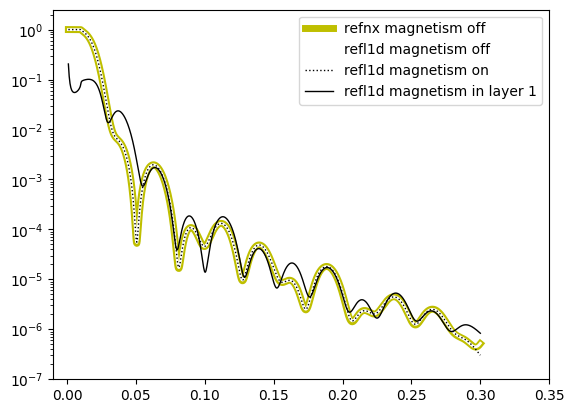

In [8]:
model_coords = np.linspace(
    start=0.001,
    stop=0.3,
    num=1000,
)

interface.switch('refnx')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_refnx = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_refnx, 'y-', label=f'{model_interface.name} magnetism off', linewidth=5)

interface.switch('refl1d')
model.interface = interface
model_interface = model.interface()
model_data_no_magnetism_ref1d = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_no_magnetism_ref1d, 'w-', label=f'{model_interface.name} magnetism off', linewidth=2)

model_interface.magnetism = True
model_data_magnetism = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism, 'k:', label=f'{model_interface.name} magnetism on', linewidth=1)

model_interface._wrapper.update_layer(list(model_interface._wrapper.storage['layer'].keys())[1], magnetism_rhoM=10, magnetism_thetaM=10)
model_data_magnetism_layer_1 = model.interface().fit_func(
    model_coords,
    model.uid,
)
plt.plot(model_coords, model_data_magnetism_layer_1, 'k-', label=f'{model_interface.name} magnetism in layer 1', linewidth=1)

ax = plt.gca()
ax.set_xlim([-0.01, 0.35])
ax.set_ylim([1e-7, 2.5])
plt.legend()
plt.yscale('log')
plt.show()

From the plots it is apparent that an increasing resolution flattens the reflectivity profile.